In [58]:
import sys
sys.path.append("/scratch/gf332/BayesOpt/boa/scripts")

import tensorflow as tf
from varz.tensorflow import Vars, minimise_l_bfgs_b, minimise_adam
from stheno.tensorflow import GP, EQ, Delta, Graph, Matern52

import numpy as np
import matplotlib.pyplot as plt

from boa.models.fully_factorized_gp_v2 import FullyFactorizedGPModel
from boa.models.gp import GPModel
from boa.models.gpar_v2 import GPARModel
from boa.models.matrix_factorized_gpar_v2 import MatrixFactorizedGPARModel

from dataset_loader import load_dataset
from experiments_v2 import prepare_gpar_data

from sklearn.model_selection import train_test_split

# Test Independent GP Model vs Reference Implementation

In [123]:
# Target function (noise free).
def f(X):
    return (np.sinc(3 * X) + 0.5 * (X - 0.5)**2).reshape(-1, 1)


# Generate X's and Y's for training.
np.random.seed(42)
X_train = np.array([
    -0.25,
    0,
    0.1,
]).reshape(-1, 1)
Y_train = f(X_train)

In [3]:
# Setup GP model and train.
model = GPModel(kernel='rbf', num_optimizer_restarts=3)
model.set_data(X_train, Y_train)
model.train()

model_v2 = FullyFactorizedGPModel(kernel='rbf', num_optimizer_restarts=3, verbose=False)
model_v2 = model_v2 | (X_train, Y_train)
model_v2.train()

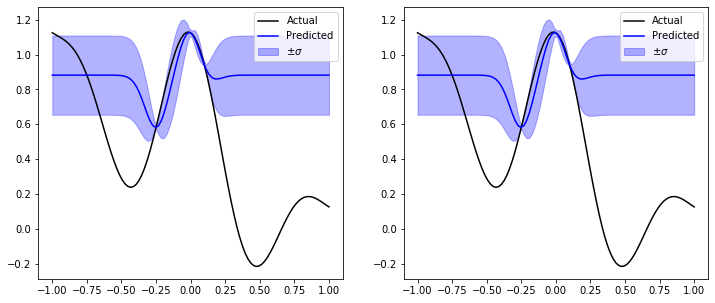

In [4]:
x_candidates = np.linspace(-1, 1, 100).reshape([-1, 1])

pred_mean, pred_var = model.predict_batch(x_candidates)

pred_mean_v2, pred_var_v2 = model_v2.predict_batch(x_candidates)

pred_mean_v2 =  pred_mean_v2.numpy()
pred_var_v2 = pred_var_v2.numpy()

plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(x_candidates, f(x_candidates), color='black', label="Actual")
plt.plot(x_candidates, pred_mean, color='blue', label="Predicted")
plt.fill_between(x_candidates.T[0], (pred_mean + np.sqrt(pred_var)).T[0], (pred_mean - np.sqrt(pred_var)).T[0], color='blue', alpha=0.3, label=r"$\pm\sigma$")

plt.legend()

plt.subplot(122)
plt.plot(x_candidates, f(x_candidates), color='black', label="Actual")
plt.plot(x_candidates, pred_mean_v2, color='blue', label="Predicted")
plt.fill_between(x_candidates.T[0], (pred_mean_v2 + np.sqrt(pred_var_v2)).T[0], (pred_mean_v2 - np.sqrt(pred_var_v2)).T[0], color='blue', alpha=0.3, label=r"$\pm\sigma$")

plt.legend()

plt.show()

# Test GP, GPAR and MF-GPAR implementations in 1-D

In [2]:
# Test function
def f(x):
    return np.sinc(3 * x[:, 0]).reshape(-1, 1)

# Set seed for reproducibility
np.random.seed(42)

# Generate input data
x_train = np.random.rand(8, 2) * 2 - 1
pseudo_point = np.array([[0.8, 0.3]])
x_train = np.vstack([x_train, pseudo_point])

y_train = f(x_train)

# Points for plotting
x_cont = np.arange(-1.5, 1.5, 0.02).reshape(-1, 1)
x_cont = np.hstack([x_cont, x_cont])

In [7]:
# FF-GP model
ff_gp = FullyFactorizedGPModel(kernel='rbf', num_optimizer_restarts=10, verbose=False)
ff_gp = ff_gp | (x_train, y_train)
ff_gp.train()

ff_gp.add_pseudo_point(pseudo_point)
y_pred_ff_gp, var_pred_ff_gp = ff_gp.predict_batch(x_cont)

y_pred_ff_gp = y_pred_ff_gp.numpy()
var_pred_ff_gp = var_pred_ff_gp.numpy()

In [3]:
# GPAR model
gpar = GPARModel(kernel='rbf', num_optimizer_restarts=10, verbose=True)
gpar = gpar | (x_train, y_train)
gpar.train()

gpar.add_pseudo_point(pseudo_point)
y_pred_gpar, var_pred_gpar = gpar.predict_batch(x_cont)

y_pred_gpar = y_pred_gpar.numpy()
var_pred_gpar = var_pred_gpar.numpy()

(<tf.Tensor: id=88, shape=(2,), dtype=float64, numpy=array([ 2.46716228e-17, -7.09309155e-17])>, <tf.Tensor: id=89, shape=(2,), dtype=float64, numpy=array([1., 1.])>)
(<tf.Tensor: id=96, shape=(1,), dtype=float64, numpy=array([-4.62592927e-17])>, <tf.Tensor: id=97, shape=(1,), dtype=float64, numpy=array([1.])>)
-------------------------------
Training iteration 1
-------------------------------
New best loss: 12.770
-------------------------------
Training iteration 2
-------------------------------
New best loss: 12.599
-------------------------------
Training iteration 3
-------------------------------
Loss: 12.770
-------------------------------
Training iteration 4
-------------------------------
Loss: 12.770
-------------------------------
Training iteration 5
-------------------------------
Loss: 12.770
-------------------------------
Training iteration 6
-------------------------------
Loss: 12.770
-------------------------------
Training iteration 7
----------------------------

In [13]:
mf_gpar = MatrixFactorizedGPARModel(latent_dim=1, kernel='rbf', num_optimizer_restarts=10, verbose=True)
mf_gpar = mf_gpar | (x_train, y_train)
mf_gpar.train()

mf_gpar.add_pseudo_point(pseudo_point)
y_pred_mf_gpar, var_pred_mf_gpar = mf_gpar.predict_batch(x_cont)

y_pred_mf_gpar = y_pred_mf_gpar.numpy()
var_pred_mf_gpar = var_pred_mf_gpar.numpy()

 /scratch/gf332/BayesOpt/tf2-boa-venv/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning:Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


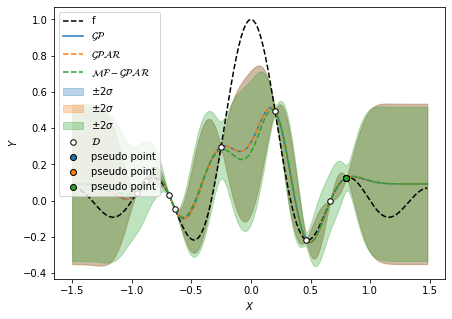

In [14]:
# Plot results
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

# Ground truth
ax.plot(x_cont[:, 0], f(x_cont), color='black', linestyle='dashed', label='f', zorder=-1)

# FF-GP predictions
ax.plot(x_cont[:, 0], y_pred_ff_gp, color='C0', zorder=-1, label=r'$\mathcal{GP}$')
ax.fill_between(x_cont.T[0],
                (y_pred_ff_gp + 2 * np.sqrt(var_pred_ff_gp)).T[0],
                (y_pred_ff_gp - 2 * np.sqrt(var_pred_ff_gp)).T[0],
                color='C0',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

# GPAR predictions
ax.plot(x_cont[:, 0], y_pred_gpar, color='C1', zorder=-1, label=r'$\mathcal{GPAR}$', linestyle='dashed')
ax.fill_between(x_cont.T[0],
                (y_pred_gpar + 2 * np.sqrt(var_pred_gpar)).T[0],
                (y_pred_gpar - 2 * np.sqrt(var_pred_gpar)).T[0],
                color='C1',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

# MF-GPAR predictions
ax.plot(x_cont[:, 0], y_pred_mf_gpar, color='C2', zorder=-1, label=r'$\mathcal{MF-GPAR}$', linestyle='dashed')
ax.fill_between(x_cont.T[0],
                (y_pred_mf_gpar + 2 * np.sqrt(var_pred_mf_gpar)).T[0],
                (y_pred_mf_gpar - 2 * np.sqrt(var_pred_mf_gpar)).T[0],
                color='C2',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

# Data points
ax.scatter(x=x_train[:, 0], y=y_train[:, 0], s=30, c='white', edgecolors='black', label=r'$\mathcal{D}$')
ax.scatter(x=ff_gp.xs[-1:, 0], y=ff_gp.ys[-1:, 0], c='C0', edgecolors='black', label='pseudo point')
ax.scatter(x=gpar.xs[-1:, 0], y=gpar.ys[-1:, 0], c='C1', edgecolors='black', label='pseudo point')
ax.scatter(x=mf_gpar.xs[-1:, 0], y=mf_gpar.ys[-1:, 0], c='C2', edgecolors='black', label='pseudo point')

ax.legend(loc='upper left')
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')

fig.show()

# GPAR Cholesky problems

In [350]:
# FFT dataset
fft_data_path = "../resources/fft_dataset.csv"

data = load_dataset(fft_data_path, "fft")
df, input_labels, output_labels = prepare_gpar_data(data, ["avg_power", "cycle", "total_area"])

train, test = train_test_split(df,
                               train_size=25,
                              test_size=200,
                              random_state=42)

x_train = tf.convert_to_tensor(train[input_labels].values, dtype=tf.float64)
y_train = tf.convert_to_tensor(train[output_labels].values, dtype=tf.float64)

x_mean, x_var = tf.nn.moments(x_train, axes=[0])
y_mean, y_var = tf.nn.moments(y_train, axes=[0])

x_std = tf.maximum(tf.sqrt(x_var), 1e-10)
y_std = tf.maximum(tf.sqrt(y_var), 1e-10)

x_train = (x_train - x_mean) / x_std
y_train = (y_train - y_mean) / y_std

In [351]:
gp_variances = []
noise_variances = []
length_scales = []

gps = []

matern_crash_logs = [
    "../logs/chol_crash_gpar_matern52_seed_27", # Crashes on index 10
    "../logs/chol_crash_gpar_matern52_seed_42", # Crashes on index 0
    "../logs"
]

rbf_crash_logs = [
    "../logs/inv_crash_gpar_rbf_seed_27", # Crashes on index 0
    "../logs/inv_crash_gpar_rbf_seed_42", # Crashes on index 0
]

crash_log = matern_crash_logs[2]
kernel = Matern52()

gp_kernels = []

for j in range(18):
    
    ls_name = crash_log + "/length_scales_dim_{}.npy".format(j)
    gp_var_name = crash_log + "/gp_variance_dim_{}.npy".format(j)
    noise_var_name = crash_log + "/noise_variance_dim_{}.npy".format(j)
    
    gp_variances.append(tf.convert_to_tensor(np.load(gp_var_name), dtype=tf.float64))
    noise_variances.append(tf.convert_to_tensor(np.load(noise_var_name), dtype=tf.float64))
    length_scales.append(tf.convert_to_tensor(np.load(ls_name), dtype=tf.float64))
    
    g = Graph()
    
    gp_kernel = gp_variances[j] * kernel.stretch(length_scales[j])
    gps.append(GP(gp_kernel, graph=g) + GP(noise_variances[j] * Delta(), graph=g))

In [352]:
tf.nn.moments(x_train, axes=[0])

(<tf.Tensor: id=26176, shape=(18,), dtype=float64, numpy=
 array([ 2.04281037e-16,  2.66453526e-17,  2.66453526e-17,  7.10542736e-17,
        -1.42108547e-16, -1.48769885e-16, -1.94289029e-16,  1.68753900e-16,
        -1.59872116e-16,  7.10542736e-17,  8.88178420e-17, -2.30926389e-16,
        -9.76996262e-17, -1.77635684e-17,  0.00000000e+00, -1.77635684e-17,
         4.44089210e-17, -3.55271368e-17])>,
 <tf.Tensor: id=26177, shape=(18,), dtype=float64, numpy=
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1.])>)

In [353]:
gps[0]

GP([0.00228806] * (Matern52() > [3.78011240e+00 1.00000000e-04 1.00000000e+04 1.00000000e+04
 4.19451659e-01 1.00000000e+04 1.00000000e+04 7.70773925e+03
 1.00000000e+04 1.00000000e+04 1.00000000e+04 1.00000000e+04
 4.16900534e-04 1.12494771e-04 1.00000000e+04 1.00000000e+04
 1.00000000e+04 1.00000000e+04]) + [0.0001] * Delta(), 0)

In [354]:
for j in range(0, 18):
    print(j)
    gp_inputs = tf.concat((x_train, y_train[:, :j]), axis=1)
    
    gps[j](gp_inputs).logpdf(y_train[:, j:j+1])

0
1
2
3
4
5
6
7
8
9
10


InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid. [Op:Cholesky]

In [355]:
i = 10

gp_input = tf.concat([x_train, y_train[:, :i]], axis=1)

K = gps[i].kernel(gp_input).mat

In [356]:
np.diag(K)

array([8167.6174846 , 8167.61758603, 8167.61718034, 8167.61758603,
       8167.61758603, 8167.61718034, 8167.6174846 , 8167.61677465,
       8167.61758603, 8167.61758603, 8167.61596327, 8167.61738318,
       8167.61677465, 8167.6174846 , 8167.61758603, 8167.61758603,
       8167.61738318, 8167.6174846 , 8167.61718034, 8167.61738318,
       8167.6174846 , 8167.61758603, 8167.61758603, 8167.6174846 ,
       8167.6174846 ])

In [360]:
tf.linalg.cholesky(K + 1e-3 * np.eye(25))

<tf.Tensor: id=27735, shape=(25, 25), dtype=float64, numpy=
array([[ 9.03748775e+01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 9.03714236e+01,  7.90177038e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.0

In [359]:
np.linalg.eigvals(K + 1e-3 * np.eye(25))

array([1.38844648e+05, 4.80833726e+00, 6.53408902e+04, 3.07851014e-02,
       1.39350412e-02, 9.37356977e-03, 6.26893353e-03, 5.93283697e-03,
       5.18893208e-03, 4.90413189e-03, 5.52397425e-03, 4.42436590e-03,
       3.28378956e-03, 3.98726472e-03, 3.99330601e-03, 2.38935684e-03,
       1.98037855e-03, 1.76894348e-03, 8.98435191e-04, 1.04057081e-03,
       6.41529132e-04, 1.18231463e-03, 1.40865103e-03, 2.26707258e-03,
       1.41466750e-03])

In [358]:
np.linalg.eigvals(K)

array([ 1.38844647e+05,  4.80733726e+00,  6.53408892e+04,  2.97851014e-02,
        1.29350412e-02,  8.37356977e-03,  5.26893353e-03,  4.93283697e-03,
        4.18893208e-03,  3.90413189e-03,  3.42436590e-03,  4.52397425e-03,
        2.98726472e-03,  2.28378956e-03,  2.99330601e-03,  1.38935685e-03,
        9.80378550e-04,  7.68943479e-04, -1.01564810e-04,  4.05708120e-05,
        1.82314631e-04, -3.58470869e-04,  4.08651031e-04,  1.26707258e-03,
        4.14667499e-04])

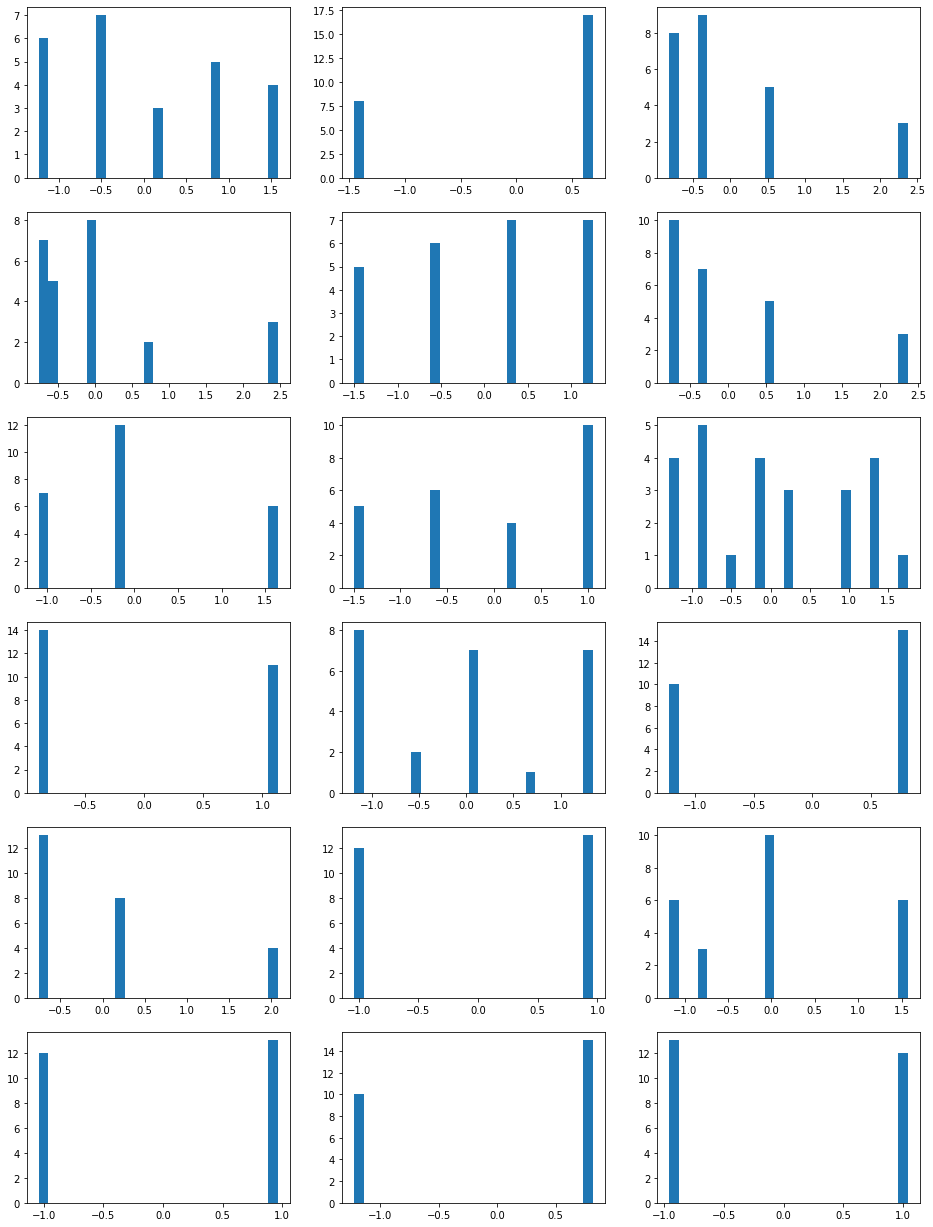

In [194]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(16, 22))

axes = np.ravel(axes)

for i in range(18):
    axes[i].hist(x_train[:, i], bins=25)

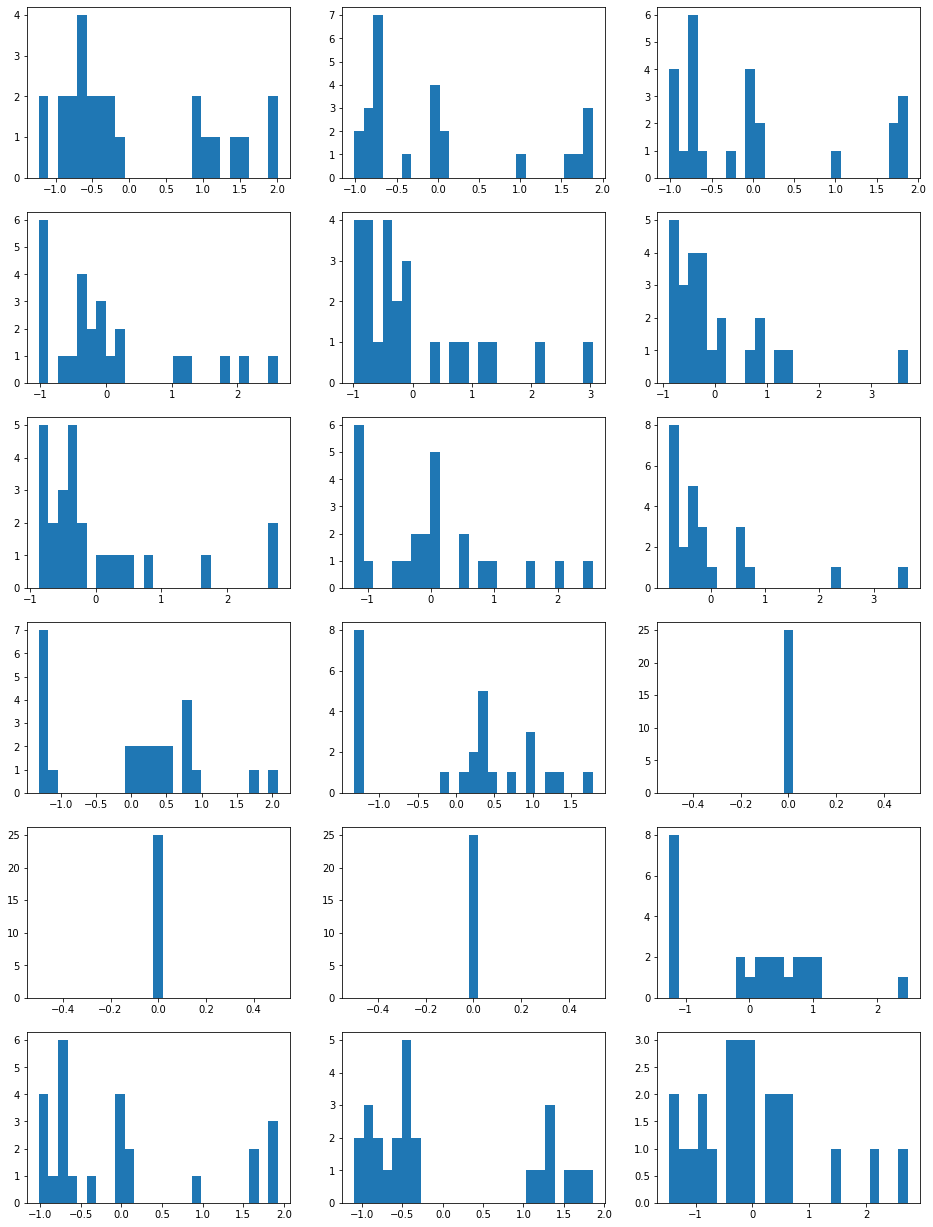

In [195]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(16, 22))

axes = np.ravel(axes)

for i in range(18):
    axes[i].hist(y_train[:, i], bins=25)

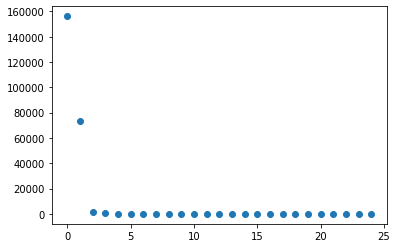

In [361]:
plt.scatter(np.arange(25), eig_vals[:])

In [362]:
eig_vals

array([1.56126048e+05, 7.34373886e+04, 1.68015393e+03, 8.24289953e+02,
       2.80233125e-01, 1.93702383e-01, 9.10543029e-03, 7.12732311e-03,
       5.69579510e-03, 5.07672333e-03, 4.00383507e-03, 3.63551940e-03,
       3.30066185e-03, 2.83966696e-03, 2.57781719e-03, 2.15146029e-03,
       1.43318379e-03, 1.08442722e-03, 7.80054226e-04, 7.02599955e-04,
       5.98960292e-04, 2.65776974e-04, 1.70493638e-04, 3.16748746e-06,
       4.41721818e-07])

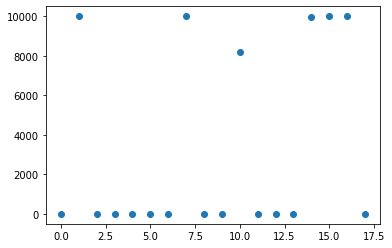

In [371]:
plt.scatter(np.arange(18), tf.convert_to_tensor(gp_variances))

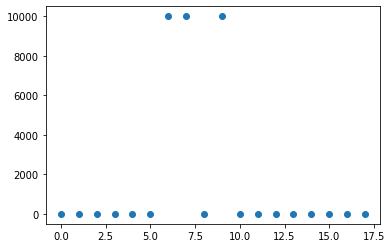

In [368]:
plt.scatter(np.arange(18), tf.convert_to_tensor(noise_variances))

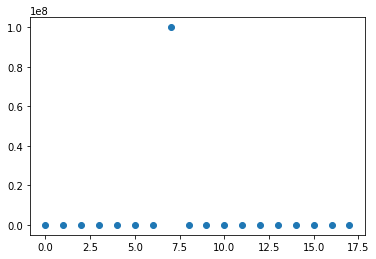

In [372]:
plt.scatter(np.arange(18), tf.convert_to_tensor(noise_variances)*tf.convert_to_tensor(gp_variances))

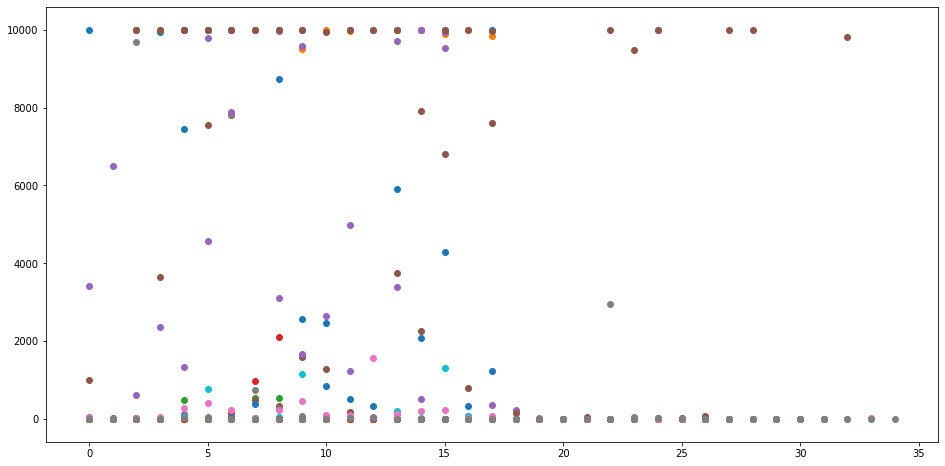

In [19]:
plt.figure(figsize=(16, 8))

for i in range(18):
    plt.scatter(np.arange(18 + i), length_scales[i])

# Test Matrix Factorized GPAR

In [18]:
t = tf.constant([3])
t

<tf.Tensor: id=638498, shape=(1,), dtype=int32, numpy=array([3], dtype=int32)>

In [19]:
t * GP(EQ())

GP([9] * EQ(), 0)

In [31]:
v = tf.Variable(1., dtype=tf.float32)
with tf.GradientTape() as tape:
    gp = v * GP(EQ())
    loglik = gp(tf.convert_to_tensor(X_train)).logpdf(tf.convert_to_tensor(Y_train))
    
tape.gradient(loglik, v)

<tf.Tensor: id=639114, shape=(), dtype=float32, numpy=247.71259>

In [15]:
GP(1e10 * EQ())(x_train).logpdf(y_train)

-101.72779718829007

In [3]:
tf.math.argmax([[1, 2, 3], [3, 4, 5]], axis=1)

<tf.Tensor: id=2, shape=(2,), dtype=int64, numpy=array([2, 2])>

In [4]:
help(minimise_l_bfgs_b)

Help on function minimise_l_bfgs_b in module varz.minimise:

minimise_l_bfgs_b(f, vs, f_calls=10000, iters=1000, trace=False, names=None)



In [306]:
vs = Vars(tf.float64)

vs.bnd(tf.ones(20), lower=1e-4, upper=2, name="haha")
vs.bnd(1e-3 * tf.ones(20), lower=1e-4, upper=2, name="hehe")

vs.get_vector()

<tf.Tensor: id=22955, shape=(40,), dtype=float64, numpy=
array([1.0000500e-04, 1.0000500e-04, 1.0000500e-04, 1.0000500e-04,
       1.0000500e-04, 1.0000500e-04, 1.0000500e-04, 1.0000500e-04,
       1.0000500e-04, 1.0000500e-04, 1.0000500e-04, 1.0000500e-04,
       1.0000500e-04, 1.0000500e-04, 1.0000500e-04, 1.0000500e-04,
       1.0000500e-04, 1.0000500e-04, 1.0000500e-04, 1.0000500e-04,
       7.7057628e+00, 7.7057628e+00, 7.7057628e+00, 7.7057628e+00,
       7.7057628e+00, 7.7057628e+00, 7.7057628e+00, 7.7057628e+00,
       7.7057628e+00, 7.7057628e+00, 7.7057628e+00, 7.7057628e+00,
       7.7057628e+00, 7.7057628e+00, 7.7057628e+00, 7.7057628e+00,
       7.7057628e+00, 7.7057628e+00, 7.7057628e+00, 7.7057628e+00])>

In [321]:
vs.assign("hehe", tf.ones(20, dtype=tf.float64))
vs.get_vector()

<tf.Tensor: id=23422, shape=(40,), dtype=float64, numpy=
array([0.00010001, 0.00010001, 0.00010001, 0.00010001, 0.00010001,
       0.00010001, 0.00010001, 0.00010001, 0.00010001, 0.00010001,
       0.00010001, 0.00010001, 0.00010001, 0.00010001, 0.00010001,
       0.00010001, 0.00010001, 0.00010001, 0.00010001, 0.00010001,
       0.00010001, 0.00010001, 0.00010001, 0.00010001, 0.00010001,
       0.00010001, 0.00010001, 0.00010001, 0.00010001, 0.00010001,
       0.00010001, 0.00010001, 0.00010001, 0.00010001, 0.00010001,
       0.00010001, 0.00010001, 0.00010001, 0.00010001, 0.00010001])>

In [329]:
vs.assign("hehe", tf.zeros(20, dtype=tf.float64))

if tf.reduce_any(tf.math.is_nan(vs["hehe"])):
    print("h")

h


In [341]:
!ls /homes/gf332/.keras/datasets/../../../../scratch/gf332/BayesOpt/data/

mnist


In [349]:
np.linspace(0.1, 0.9, 10)

array([0.1       , 0.18888889, 0.27777778, 0.36666667, 0.45555556,
       0.54444444, 0.63333333, 0.72222222, 0.81111111, 0.9       ])